# One-Shot Recognition of Manufacturing Defects in Steel Surfaces

#### If you use this code, please cite our work: [[paper](https://doi.org/10.1016/j.promfg.2020.05.146)][[code](https://github.com/adipandas/one-shot-steel-surfaces)]

### Aditya M. Deshpande, Ali A. Minai, Manish Kumar, One-Shot Recognition of Manufacturing Defects in Steel Surfaces, Procedia Manufacturing, Volume 48, 2020, Pages 1064-1071, ISSN 2351-9789, https://doi.org/10.1016/j.promfg.2020.05.146.

#### MIT License

Copyright (c) 2020 Aditya M. Deshpande

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Set Configs

In [3]:
TRAIN_DIR = './datasets_all/training/'
TEST_DIR = './datasets_all/testing/'

WEIGHT_PATH = './weights/steel/siamese'
SAVE_IMAGE_PATH = './assets/'

SAVE_TEST_RESULTS_PATH = './assets/test_output'

device = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')

## Parameters

In [4]:
BATCH_SIZE = 32
N_EPOCHS = 100
LR = 0.0005
N_GPU = 1
SET_L = True
INPUT_D = 3 if SET_L == False else 1

## Set Helpers

In [5]:
def show_img(img, text=None, figsize=(20,20), save_into=None):
    img = img.numpy()
    plt.figure(figsize=figsize)
    plt.axis('off')
    if text:
        plt.text(50, 8, text, bbox={'facecolor': 'white', 'alpha': 1 })
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    if save_into:
        plt.savefig(save_into)
        plt.show()
    else:
        plt.show()

In [6]:
def explain_databatch(batch):
    """
    batch: tensor batch from dataset
    """
    print('Each batch of training data is a tuple of {} elements.'.format(len(batch)))
    
    print('Shape of each element of a tuple in the batch:')
    for i in range(len(batch)):
        print('element#{}: {}'.format(i, batch[i].shape))

## Custom Data Loader

In [7]:
class SiameseDataset(torch.utils.data.Dataset):
    """
    Load dataset for training the network
    """
    
    def __init__(self,
                 datasets, 
                 train=True,
                 transform=None,
                 should_invert=True,
                 set_luminance=True):
        
        self.datasets = datasets
        self.train = train
        self.transform = transform
        self.should_invert = should_invert
        self.set_luminance = set_luminance
        
    def __getitem__(self, index):
        
        # selt.datasets vai ser sempre um objeto torch que pega no diretorio
        # especificado no código, com a função torchvision.datasets.ImageFolder
        imageA_tupple = random.choice(self.datasets.imgs)
        get_same_class = random.randint(0,1)
        if get_same_class:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] == imageB_tupple[1]:
                    break
        else:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] != imageB_tupple[1]:
                    break
                    
        imageA = Image.open(imageA_tupple[0])
        imageB = Image.open(imageB_tupple[0])
        
        # transforma a imagem em preto e branco
        if self.set_luminance:
            imageA = imageA.convert('L')
            imageB = imageB.convert('L')
        
        # inversão de cor
        if self.should_invert:
            imageA = ImageOps.invert(imageA)
            imageB = ImageOps.invert(imageB)
        
        if self.transform is not None:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)
        
        if self.train:
            return imageA, imageB, torch.from_numpy(np.array([int(imageA_tupple[1] != imageB_tupple[1])],
                                              dtype=np.float32))
        else:
            return imageA, imageA_tupple[0], imageA_tupple[1], imageB, imageB_tupple[0], imageB_tupple[1]
        
    def __len__(self):
        return len(self.datasets.imgs)

In [8]:
class RandRotateTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)


In [9]:
transform = transforms.Compose([
                            transforms.Resize((100,100)),
                            RandRotateTransform(angles=[0, 90, 180, 270]),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
])

In [10]:
datasets = torchvision.datasets.ImageFolder(root=TRAIN_DIR)

## Visualize Data

In [11]:
transform_visualize = transforms.Compose([
                            transforms.Resize((100,100)),
                            RandRotateTransform(angles=[0, 90, 180, 270]),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
])

siamese_datasets = SiameseDataset(datasets=datasets,
                                  train=True,
                                  transform=transform_visualize,
                                  should_invert=False,
                                  set_luminance=SET_L)

data_loader = DataLoader(siamese_datasets,
                         shuffle=True,
                         batch_size=BATCH_SIZE)

example_batch = next(iter(data_loader))
print('Total Datasets:', len(datasets), '\n')

explain_databatch(example_batch)

print('\nEach batch of the dataset 3 elements: 2 images and their similarity label')

Total Datasets: 900 

Each batch of training data is a tuple of 3 elements.
Shape of each element of a tuple in the batch:
element#0: torch.Size([32, 1, 100, 100])
element#1: torch.Size([32, 1, 100, 100])
element#2: torch.Size([32, 1])

Each batch of the dataset 3 elements: 2 images and their similarity label


#### Plot sample of a batch from dataset

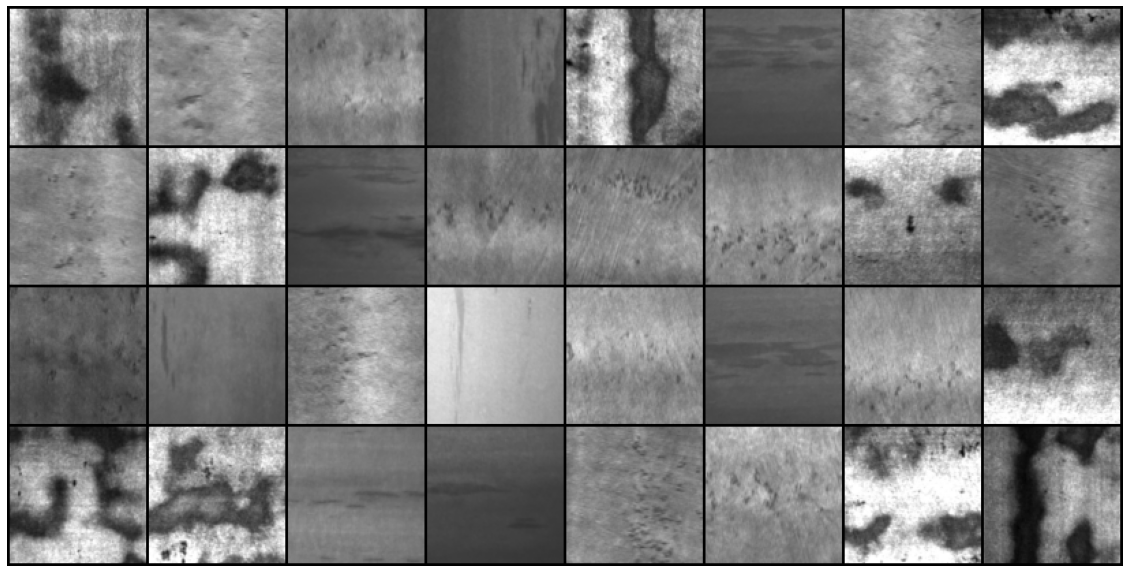

In [12]:
concatenated = torch.cat((example_batch[0][:16], example_batch[1][:16]), 0)

show_img(
    torchvision.utils.make_grid(concatenated), save_into=os.path.join(SAVE_IMAGE_PATH, 'datasets_images.png')
)

## Prepare Training Data

In [13]:
siamese_datasets = SiameseDataset(datasets=datasets,
                                  transform=transform,
                                  should_invert=False,
                                  set_luminance=SET_L)

train_loader = DataLoader(siamese_datasets,
                          shuffle=True,
                          num_workers=0,
                          batch_size=BATCH_SIZE)

#### Visualize dataloader

Each batch of training data is a tuple of 3 elements.
Shape of each element of a tuple in the batch:
element#0: torch.Size([32, 1, 100, 100])
element#1: torch.Size([32, 1, 100, 100])
element#2: torch.Size([32, 1])


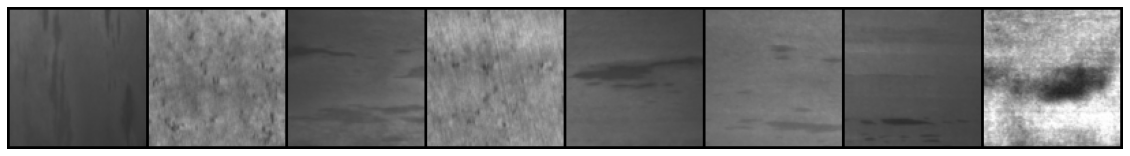

torch.Size([3, 104, 818])


In [14]:
siamese_datasets_ = SiameseDataset(datasets=datasets,
                                  transform=transform_visualize,
                                  should_invert=False,
                                  set_luminance=SET_L)

train_loader_ = DataLoader(siamese_datasets_,
                          shuffle=True,
                          num_workers=0,
                          batch_size=BATCH_SIZE)

example_batch = next(iter(train_loader_))

explain_databatch(example_batch)

concatenated = torch.cat((example_batch[0][:4],
                          example_batch[1][:4]), 0)

show_img(torchvision.utils.make_grid(concatenated),
         save_into=os.path.join(SAVE_IMAGE_PATH, 'train_images.png'))

print(torchvision.utils.make_grid(concatenated).shape)

### Siamese Network

In [15]:
class SiamaseNet(nn.Module):
    
    def __init__(self):
        super(SiamaseNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(INPUT_D, 4, kernel_size=3),
            nn.ReLU(),        
            nn.ZeroPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(),
            nn.ZeroPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 5),
        )
        
    def forward_once(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB

#### Initialize Siamese Network

In [16]:
siamese = SiamaseNet().to(device)

### Contrastive Loss Function

In [17]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, resultA, resultB, label):
        euclidean_distance = 0.5*F.pairwise_distance(resultA, resultB, keepdim=True) # L2 Norm
        
        contrastive_loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return contrastive_loss

In [18]:
contrastive_loss = ContrastiveLoss()

## Set Optimizer

In [20]:
optimizer = optim.Adam(siamese.parameters(), lr=LR)

## Train The Network

In [21]:
train_loss = 0
train_loss_history = []

N = len(datasets)

for epoch in range(N_EPOCHS):
    for batch_idx, data in enumerate(train_loader):
        imageA, imageB, label = data
        imageA, imageB, label = imageA.to(device), imageB.to(device), label.to(device)
        
        optimizer.zero_grad()
        resultA, resultB = siamese(imageA, imageB)
        loss = contrastive_loss(resultA, resultB, label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    BatchCount_PER_EPOCH = N//BATCH_SIZE
    train_loss = train_loss/BatchCount_PER_EPOCH
    train_loss_history.append(train_loss)
    
    print('Train Epoch:{}\t\tLoss:{:.6f}'.format(epoch+1, train_loss))

    if not os.path.exists(WEIGHT_PATH):
        os.makedirs(WEIGHT_PATH)
    torch.save(siamese, os.path.join(WEIGHT_PATH, 'siamese_{:03}.pt'.format(epoch+1)))
    train_loss = 0
    
    siamese.train()

Train Epoch:1		Loss:1.403685
Train Epoch:2		Loss:0.927282
Train Epoch:3		Loss:0.625490
Train Epoch:4		Loss:0.491293
Train Epoch:5		Loss:0.527766
Train Epoch:6		Loss:0.416722
Train Epoch:7		Loss:0.334572
Train Epoch:8		Loss:0.438132
Train Epoch:9		Loss:0.447831
Train Epoch:10		Loss:0.231294
Train Epoch:11		Loss:0.273285
Train Epoch:12		Loss:0.220334
Train Epoch:13		Loss:0.164676
Train Epoch:14		Loss:0.182599
Train Epoch:15		Loss:0.216749
Train Epoch:16		Loss:0.190948
Train Epoch:17		Loss:0.368028
Train Epoch:18		Loss:0.244339
Train Epoch:19		Loss:0.235486
Train Epoch:20		Loss:0.194822
Train Epoch:21		Loss:0.192895
Train Epoch:22		Loss:0.146789
Train Epoch:23		Loss:0.160803
Train Epoch:24		Loss:0.209797
Train Epoch:25		Loss:0.268751
Train Epoch:26		Loss:0.143962
Train Epoch:27		Loss:0.136483
Train Epoch:28		Loss:0.150962
Train Epoch:29		Loss:0.115460
Train Epoch:30		Loss:0.094296
Train Epoch:31		Loss:0.122739
Train Epoch:32		Loss:0.087691
Train Epoch:33		Loss:0.098924
Train Epoch:34		Los

### To save data

In [22]:
training_data = np.array(train_loss_history)
np.save("training_history", training_data)
training_data = np.load("training_history.npy")

## Evaluate The Network

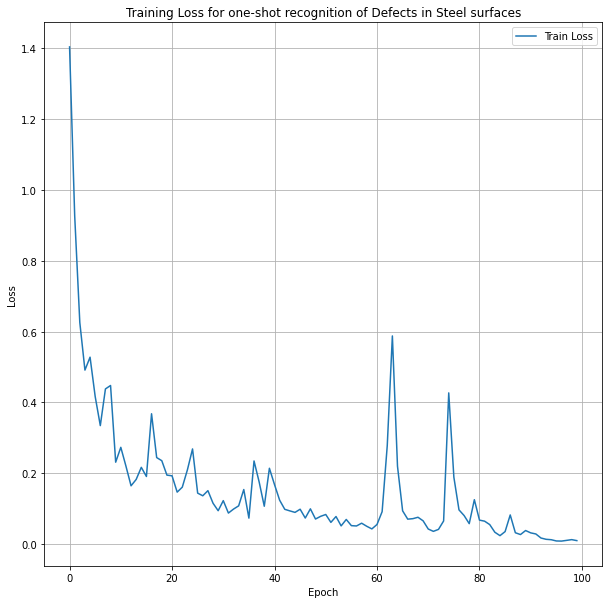

In [23]:
plt.figure(figsize=(10,10))
plt.title("Training Loss for one-shot recognition of Defects in Steel surfaces")
plt.plot(training_data, label="Train Loss")

plt.xlabel("Epoch")
plt.grid(True)
plt.ylabel("Loss")
plt.legend()

if not os.path.exists(SAVE_IMAGE_PATH):
    os.makedirs(SAVE_IMAGE_PATH)
    
plt.savefig(os.path.join(SAVE_IMAGE_PATH, 'final_train_loss.svg'),
            quality=95, dpi=400, pad_inches=0, bbox_inches='tight')
plt.show()

In [24]:
TEST_DIR = './datasets_all/testing/'
class_list = os.listdir(TEST_DIR)
class_list.sort()

In [25]:
test_datasets = torchvision.datasets.ImageFolder(root=TEST_DIR)
siamese_test_datasets = SiameseDataset(datasets=test_datasets,
                                       train=False,
                                       transform=transform,
                                       should_invert=False,
                                       set_luminance=SET_L)

In [26]:
siamese = torch.load("./weights/steel/siamese/siamese_100.pt")
siamese.eval()

SiamaseNet(
  (conv_layer): Sequential(
    (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [27]:
SAVE_TEST_RESULTS_PATH = "./assets/paper"
SAVE_TEST_RESULTS = "./assets/paper"

In [33]:
test_loader = DataLoader(siamese_test_datasets,
                         num_workers=0,
                         batch_size=1,
                         shuffle=True)

data_iter = iter(test_loader)

correct_ = 0
count = 0
for i in range(len(siamese_test_datasets)):
    try:
        count += 1
        imageA, pathA, classA, imageB, pathB, classB = next(data_iter)
    except:
        break
    
    with torch.no_grad():
        resultA, resultB = siamese(Variable(imageA).to(device), Variable(imageB).to(device))
        euclidean_distance = F.pairwise_distance(resultA, resultB)
        
        if euclidean_distance>=2. and classA!=classB:
            correct_ += 1
        elif euclidean_distance<2. and classA==classB:
            correct_ += 1
                
    concatenated = torch.cat((imageA, imageB),0)
    
    # Uncomment below lines to save figures
    image_file_name = 'test_output_{}.png'.format(i)
    save_results_in = os.path.join(SAVE_TEST_RESULTS_PATH, image_file_name)

print('Accuracy of the network on the test images: %d %%' % (100 * correct_ / count))

Accuracy of the network on the test images: 64 %
